In [2]:
%matplotlib inline

from __future__ import division

import math
import operator
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature, io, color, filters
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import corner_harris, corner_subpix, corner_peaks


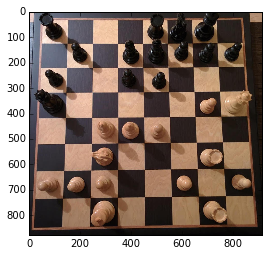

In [3]:
image = io.imread("samples/sample_crop.jpg")

plt.imshow(image, cmap=plt.cm.gray)
plt.show()

[]

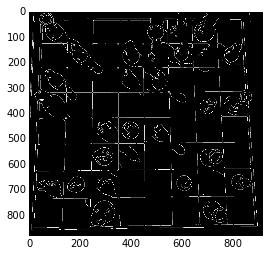

In [5]:
img_hsv = color.convert_colorspace(image, 'RGB', 'HSV')
image_hue = img_hsv[:,:,1]
image_blue = image[:,:,2]
image_gray = color.rgb2gray(image)
image_canny = feature.canny(image_gray, 2)
plt.imshow(image_canny, cmap=plt.cm.gray)
plt.plot()

[]

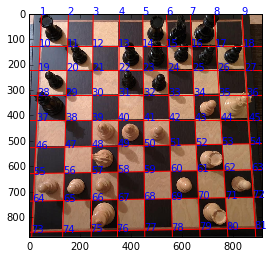

In [6]:
# finds coordinates where the Hough lines intersect
# find horizontal and vertical lines, and compute their intersects 
# return coordinates from top to bottom and left to right
def find_edges(hough_peaks, image_shape):
    horizontals = []
    verticals = []
    intersections = []
    max_y, max_x = image_shape
    
    for _, theta, r in zip(*hough_peaks):
        if abs(theta) < 0.2:
            verticals.append((theta, r))
        elif abs(abs(theta) - math.pi/2) < 0.2:
            horizontals.append((abs(theta), abs(r)))
    
    # edges will be returned from top to bottom, and from left to right
    horizontals.sort(key=operator.itemgetter(1))
    verticals.sort(key=operator.itemgetter(1))
    
    for theta1, r1 in horizontals:
        for theta2, r2 in verticals:
            # can this be numerically unstable? denum is below 1e-10 in some cases here
            denum = np.cos(theta1)*np.sin(theta2) - np.sin(theta1)*np.cos(theta2)
            x_inter = (r1*np.sin(theta2) - r2*np.sin(theta1)) / denum
            y_inter = (r2*np.cos(theta1) - r1*np.cos(theta2)) / denum
            if 0 < x_inter and x_inter < max_x and 0 < y_inter and y_inter < max_y:
                intersections.append((x_inter, y_inter))
                
    return np.array(intersections)
       
# plot chessboard with lines and intersections
h, theta, d = hough_line(image_canny)
rows, cols = image_canny.shape

plt.imshow(image, cmap=plt.cm.gray)
peaks = hough_line_peaks(h, theta, d, min_distance=25, threshold=150)
edges = find_edges(peaks, image_canny.shape)

for _, angle, dist in zip(*peaks):
    # print angle, dist
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r')

for i,edge in enumerate(edges,1):
    plt.text(edge[0], edge[1], str(i), color='blue')

plt.axis((0, cols, rows, 0))
plt.plot()

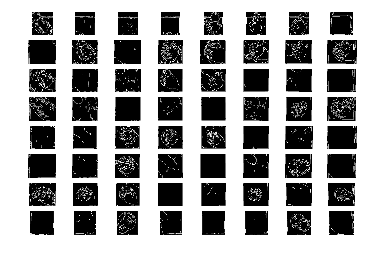

In [7]:
# return a numpy array where each entry is the image of a square
def find_squares(edges):
    edges_matrix = np.zeros((9,9), dtype=(float,2))
    images_matrix = np.empty((8,8), dtype=object)
    for i,edge in enumerate(edges): # probably equivalent to some smart reshape
        edges_matrix[math.floor(i/9), i % 9] = edge
    
    for i in range(8):
        for j in range(8):
            top_left = edges_matrix[i][j]
            bottom_right = edges_matrix[i+1][j+1]
            square_image = image[math.floor(top_left[1]):math.ceil(bottom_right[1]), math.floor(top_left[0]):math.ceil(bottom_right[0])]
            images_matrix[i,j] = square_image
    return images_matrix

def print_all_squares(squares):
    fig, axes = plt.subplots(nrows=8, ncols=8)
    for i in range(8):
        for j in range(8):
            axes[i][j].imshow(squares[i,j], cmap=plt.cm.gray)
            axes[i][j].axis('off') 
    plt.plot()

squares = find_squares(edges)
# print_all_squares(squares)

# perform canny edge detection on each square
img_matrix = np.empty((8,8), dtype=object)
for i in range(8):
    for j in range(8):
        img = squares[i,j]
        img_gray = color.rgb2gray(img)
        img_canny = feature.canny(img_gray, 0.5)
        img_matrix[i,j] = img_canny

print_all_squares(img_matrix)

[[ 1.  0.  0.  0.  1.  1.  1.  0.]
 [ 0.  1.  0.  1.  1.  1.  1.  1.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  1.  1.]
 [ 0.  0.  1.  1.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  1.  0.]
 [ 1.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  1.  0.]]
Estimated occupancy matrix
Errors:  4


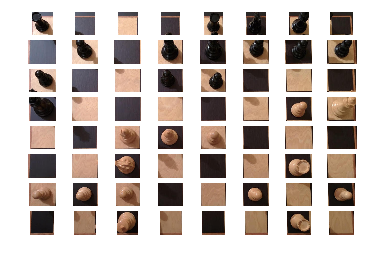

In [13]:
# use a hard threshold on the proportion of white pixels in the canny-filtered images
# to classify empty and occupied squares

output = np.zeros((8,8))
for i in range(8):
    for j in range(8):
        img = img_matrix[i,j]
        output[i,j] = np.sum(img) / img.size > 0.1  # hard threshold, not cool.
print(output)

print_all_squares(squares)

print("Estimated occupancy matrix")
ref = np.array([[1,0,0,0,1,1,1,0],[0,1,0,1,1,1,1,1],[1,0,0,1,1,0,0,0],
                [1,0,0,0,0,0,1,1],[0,0,1,1,1,0,0,0],[0,0,1,0,0,0,1,0],
               [1,1,1,0,0,1,0,1], [0,0,1,0,0,0,1,0]])
print("Errors: ", int(np.sum(np.abs(ref-output))))

In [ ]:
# TODO
# use ML to classify the images?  normalized canny + SVM / SIFT + bag of words / convNet ?
# use some preprocessing to make the thresholds less image-dependent (histogram normalization?)